### Materials

In [1]:
import pandas
import numpy as np
import os
import shutil
import torch

In [7]:
labels = ["can","bottle"]
for label in labels:
    os.makedirs(f'material_classification/train/{label}')
    os.makedirs(f'material_classification/val/{label}')
    os.makedirs(f'material_classification/test/{label}')

In [8]:
bottle_train_count = 0
bottle_val_count = 0
bottle_test_count = 0
can_train_count = 0
can_val_count = 0
can_test_count = 0

sub_dir = ["coca cola can", "coca cola plastic bottle", "fanta can", 
           "fanta plastic bottle", "7up can", "7up plastic bottle"]
for d in sub_dir:
    if d.split()[-1] == "bottle":
        for f in os.listdir(f'DATA/data/{d}'):
            if bottle_train_count < 2400:
                shutil.copy(f'DATA/data/{d}/'+f,f'material_classification/train/bottle/{bottle_train_count}.jpg')
                bottle_train_count += 1
            elif bottle_val_count < 300:
                shutil.copy(f'DATA/data/{d}/'+f,f'material_classification/val/bottle/{bottle_val_count}.jpg')
                bottle_val_count += 1
            elif bottle_test_count < 300:
                shutil.copy(f'DATA/data/{d}/'+f,f'material_classification/test/bottle/{bottle_test_count}.jpg')
                bottle_test_count += 1
    elif d.split()[-1] == "can":
        for f in os.listdir(f'DATA/data/{d}'):
            if can_train_count < 2400:
                shutil.copy(f'DATA/data/{d}/'+f,f'material_classification/train/can/{can_train_count}.jpg')
                can_train_count += 1
            elif can_val_count < 300:
                shutil.copy(f'DATA/data/{d}/'+f,f'material_classification/val/can/{can_val_count}.jpg')
                can_val_count += 1
            elif can_test_count < 300:
                shutil.copy(f'DATA/data/{d}/'+f,f'material_classification/test/can/{can_test_count}.jpg')
                can_test_count += 1

In [2]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from collections import OrderedDict

In [3]:
dataset_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.RandomRotation(30),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dir = 'material_classification/train'
val_dir = 'material_classification/val'
test_dir = 'material_classification/test'

In [5]:
# Create train, validation and test dataset
train_dataset = datasets.ImageFolder(train_dir,transform=dataset_transform)
val_dataset = datasets.ImageFolder(val_dir,transform=dataset_transform)
test_dataset = datasets.ImageFolder(test_dir,transform=dataset_transform)

In [6]:
# Load datasets into dataloader for iteration
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 100, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = True)

In [7]:
# Training function
def training(model):
    iteration = 0
    minLoss = float("inf")
    best_parameters = None

    # Training Loop
    for epoch in range(epochs):
        # Iterate over the training dataloader
        for i, (images, labels) in enumerate(train_dataloader):
            # Reinitialize the gradient
            optimizer.zero_grad()

            # Get the correct label
            images, labels = images.to(device), labels.to(device)

            # Forward propagation
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Use the loss for back propagation
            loss.backward()

            # Update network parameters
            optimizer.step()
            
            # Empty the cache of GPU
            del images
            del labels
            del loss
            del outputs
            torch.cuda.empty_cache()

            iteration += 1

            if iteration % 10 == 0 or iteration == 1:
                # Calculate Accuracy and loss        
                correct = 0
                total = 0

                total_loss = 0

                # Validation Loop
                # Iterate over the validation dataloader
                for images, labels in val_dataloader:

                    images, labels = images.to(device), labels.to(device)
                    # Make prediction
                    outputs = model(images)

                    loss = criterion(outputs, labels)
                    total_loss += float(loss)

                    # Get predictions from the maximum value, index 0 is the maximum value, 
                    # index 1 is the index of the maximum value
                    _, predicted = torch.max(outputs.data, 1)

                    # Number of labels
                    total += labels.size(0)

                    # Number of correct predictions
                    correct += (predicted == labels).sum()
                    
                    # Empty cache of GPU
                    del images
                    del labels
                    del loss
                    del outputs
                    torch.cuda.empty_cache()

                # Calculate accuracy
                accuracy = 100 * correct / total

                # Save parameters if loss is smaller
                if total_loss < minLoss:
                    minLoss = total_loss
                    best_parameters = model.state_dict()

                # Print accuracy and loss
                print(f'Iteration {iteration}: Loss: {total_loss}, Validation accuracy: {accuracy}')
    return best_parameters

In [8]:
import matplotlib.pyplot as plt
# Testing
def test(model):
    correct = 0
    total = 0
    total_loss = 0
    count = 0

    # Test Loop
    for images, labels in test_dataloader:

        images, labels = images.to(device), labels.to(device)

        # Make prediction
        outputs = model(images)

        loss = criterion(outputs, labels)
        total_loss += float(loss)

        # Get predictions from the maximum value, index 0 is the maximum value, 
        # index 1 is the index of the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Number of labels
        total += labels.size(0)

        # Number of correct predictions
        correct += (predicted == labels).sum()
        
        # Empty cache
        del images
        del labels
        del loss
        del outputs
        torch.cuda.empty_cache()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print accuracy and loss
    print(f'Best model has Loss: {total_loss}, Test accuracy: {accuracy}')

In [22]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=2)

In [24]:
# Only unfreeze the last two layer
to_update = ["classifier.6.weight", "classifier.6.bias"]
to_update_params = []
for name, param in alexnet.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [25]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [26]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

In [27]:
# Training
alexnet_best_parameters = training(alexnet)

Iteration 1: Loss: 47.93917274475098, Validation accuracy: 50.0
Iteration 10: Loss: 16.255776405334473, Validation accuracy: 74.0


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Iteration 20: Loss: 11.727100729942322, Validation accuracy: 65.5
Iteration 30: Loss: 11.097225189208984, Validation accuracy: 68.16667175292969
Iteration 40: Loss: 8.441110968589783, Validation accuracy: 72.0
Iteration 50: Loss: 5.902715802192688, Validation accuracy: 78.16667175292969
Iteration 60: Loss: 7.775844037532806, Validation accuracy: 75.16667175292969
Iteration 70: Loss: 10.385002374649048, Validation accuracy: 73.33333587646484
Iteration 80: Loss: 6.012451767921448, Validation accuracy: 76.33333587646484
Iteration 90: Loss: 7.429458141326904, Validation accuracy: 72.66667175292969
Iteration 100: Loss: 7.25816798210144, Validation accuracy: 78.33333587646484
Iteration 110: Loss: 6.5148080587387085, Validation accuracy: 77.66667175292969
Iteration 120: Loss: 7.581126093864441, Validation accuracy: 75.66667175292969
Iteration 130: Loss: 7.060234010219574, Validation accuracy: 77.5
Iteration 140: Loss: 8.839765787124634, Validation accuracy: 74.83333587646484
Iteration 150: Lo

In [28]:
torch.save(alexnet_best_parameters, ModelPath+'/alexnet_params.pt')

In [29]:
alexnet.load_state_dict(torch.load(f"{ModelPath}/alexnet_params.pt"))

<All keys matched successfully>

In [30]:
test(alexnet)

C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Best model has Loss: 13.982308268547058, Test accuracy: 74.33333587646484


## GoogleNet

In [9]:
googlenet = models.googlenet(pretrained=True)
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
googlenet.fc = nn.Linear(in_features=1024, out_features=3, bias=True)

In [11]:
# Only unfreeze the last two layer
to_update = ["fc.weight", "fc.bias"]
to_update_params = []
for name, param in googlenet.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [12]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [13]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

In [14]:
# Training
googlenet_best_parameters = training(googlenet)

Iteration 1: Loss: 4.074621200561523, Validation accuracy: 57.833335876464844


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Iteration 10: Loss: 4.023590862751007, Validation accuracy: 63.0
Iteration 20: Loss: 4.841966867446899, Validation accuracy: 60.0
Iteration 30: Loss: 3.7580400705337524, Validation accuracy: 71.33333587646484
Iteration 40: Loss: 3.6004071831703186, Validation accuracy: 73.5
Iteration 50: Loss: 3.6662537455558777, Validation accuracy: 72.16667175292969
Iteration 60: Loss: 3.713538944721222, Validation accuracy: 73.16667175292969
Iteration 70: Loss: 3.5518932938575745, Validation accuracy: 72.5
Iteration 80: Loss: 3.5531448125839233, Validation accuracy: 72.16667175292969
Iteration 90: Loss: 3.6549256443977356, Validation accuracy: 73.16667175292969
Iteration 100: Loss: 3.655289649963379, Validation accuracy: 74.33333587646484
Iteration 110: Loss: 3.48086416721344, Validation accuracy: 74.0
Iteration 120: Loss: 3.512359857559204, Validation accuracy: 71.5
Iteration 130: Loss: 3.9023630023002625, Validation accuracy: 70.66667175292969
Iteration 140: Loss: 3.578216016292572, Validation acc

In [15]:
import os
ModelPath = 'material_best_models'
if not os.path.exists(ModelPath):
    os.makedirs(ModelPath)

In [16]:
# save the model params
torch.save(googlenet_best_parameters, ModelPath+'/googlenet_params.pt')

In [20]:
googlenet.load_state_dict(torch.load(f"{ModelPath}/googlenet_params.pt"))

<All keys matched successfully>

In [21]:
test(googlenet)

Best model has Loss: 4.62934148311615, Test accuracy: 66.5


### Ensemble model

In [31]:
from torchensemble import VotingClassifier 

In [32]:
ensemble_vote = VotingClassifier(estimator=alexnet, n_estimators=10)
criterion = nn.CrossEntropyLoss()
ensemble_vote.set_criterion(criterion)
ensemble_vote.set_optimizer("Adam", lr=0.01)
ensemble_vote.fit(train_dataloader, epochs=10)

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 0.60182 | Correct: 88/100
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 0.55235 | Correct: 93/100
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 0.83160 | Correct: 92/100
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 0.49801 | Correct: 89/100
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 0.45371 | Correct: 90/100
Estimator: 005 | Epoch: 000 | Batch: 000 | Loss: 0.67028 | Correct: 89/100
Estimator: 006 | Epoch: 000 | Batch: 000 | Loss: 0.79295 | Correct: 83/100
Estimator: 007 | Epoch: 000 | Batch: 000 | Loss: 1.86148 | Correct: 80/100
Estimator: 008 | Epoch: 000 | Batch: 000 | Loss: 0.60376 | Correct: 91/100
Estimator: 009 | Epoch: 000 | Batch: 000 | Loss: 0.73127 | Correct: 91/100
Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 0.85768 | Correct: 90/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 0.84633 | Correct: 88/100
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 0.70867 | Correct: 90/100
Estimator: 003 | Epoch: 001 | Batch: 000 | Loss: 0.42376 | Correct: 95/100
Estimator: 004 | Epoch: 001 | Batch: 000 | Loss: 0.46450 | Correct: 96/100
Estimator: 005 | Epoch: 001 | Batch: 000 | Loss: 0.54265 | Correct: 89/100
Estimator: 006 | Epoch: 001 | Batch: 000 | Loss: 0.33852 | Correct: 92/100
Estimator: 007 | Epoch: 001 | Batch: 000 | Loss: 0.42327 | Correct: 91/100
Estimator: 008 | Epoch: 001 | Batch: 000 | Loss: 0.88655 | Correct: 87/100
Estimator: 009 | Epoch: 001 | Batch: 000 | Loss: 1.07826 | Correct: 86/100
Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 0.37678 | Correct: 92/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 002 | Batch: 000 | Loss: 0.87958 | Correct: 88/100
Estimator: 002 | Epoch: 002 | Batch: 000 | Loss: 0.74520 | Correct: 86/100
Estimator: 003 | Epoch: 002 | Batch: 000 | Loss: 0.70898 | Correct: 86/100
Estimator: 004 | Epoch: 002 | Batch: 000 | Loss: 1.43667 | Correct: 80/100
Estimator: 005 | Epoch: 002 | Batch: 000 | Loss: 0.89532 | Correct: 86/100
Estimator: 006 | Epoch: 002 | Batch: 000 | Loss: 1.37625 | Correct: 83/100
Estimator: 007 | Epoch: 002 | Batch: 000 | Loss: 0.31291 | Correct: 92/100
Estimator: 008 | Epoch: 002 | Batch: 000 | Loss: 0.91760 | Correct: 90/100
Estimator: 009 | Epoch: 002 | Batch: 000 | Loss: 1.24130 | Correct: 83/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 0.41313 | Correct: 92/100
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 0.93024 | Correct: 87/100
Estimator: 002 | Epoch: 003 | Batch: 000 | Loss: 1.12225 | Correct: 87/100
Estimator: 003 | Epoch: 003 | Batch: 000 | Loss: 0.58673 | Correct: 89/100
Estimator: 004 | Epoch: 003 | Batch: 000 | Loss: 0.23591 | Correct: 95/100
Estimator: 005 | Epoch: 003 | Batch: 000 | Loss: 0.80650 | Correct: 89/100
Estimator: 006 | Epoch: 003 | Batch: 000 | Loss: 1.03891 | Correct: 82/100
Estimator: 007 | Epoch: 003 | Batch: 000 | Loss: 1.52586 | Correct: 80/100
Estimator: 008 | Epoch: 003 | Batch: 000 | Loss: 1.35687 | Correct: 80/100
Estimator: 009 | Epoch: 003 | Batch: 000 | Loss: 0.59790 | Correct: 89/100
Estimator: 000 | Epoch: 004 | Batch: 000 | Loss: 0.61865 | Correct: 89/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 004 | Batch: 000 | Loss: 1.72752 | Correct: 79/100
Estimator: 002 | Epoch: 004 | Batch: 000 | Loss: 1.13994 | Correct: 85/100
Estimator: 003 | Epoch: 004 | Batch: 000 | Loss: 0.53246 | Correct: 90/100
Estimator: 004 | Epoch: 004 | Batch: 000 | Loss: 0.75791 | Correct: 92/100
Estimator: 005 | Epoch: 004 | Batch: 000 | Loss: 1.22671 | Correct: 86/100
Estimator: 006 | Epoch: 004 | Batch: 000 | Loss: 0.89624 | Correct: 89/100
Estimator: 007 | Epoch: 004 | Batch: 000 | Loss: 1.03411 | Correct: 82/100
Estimator: 008 | Epoch: 004 | Batch: 000 | Loss: 0.44007 | Correct: 90/100
Estimator: 009 | Epoch: 004 | Batch: 000 | Loss: 1.34994 | Correct: 81/100
Estimator: 000 | Epoch: 005 | Batch: 000 | Loss: 0.28672 | Correct: 93/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 005 | Batch: 000 | Loss: 0.36902 | Correct: 94/100
Estimator: 002 | Epoch: 005 | Batch: 000 | Loss: 0.83652 | Correct: 93/100
Estimator: 003 | Epoch: 005 | Batch: 000 | Loss: 0.80432 | Correct: 87/100
Estimator: 004 | Epoch: 005 | Batch: 000 | Loss: 1.35994 | Correct: 82/100
Estimator: 005 | Epoch: 005 | Batch: 000 | Loss: 1.14082 | Correct: 82/100
Estimator: 006 | Epoch: 005 | Batch: 000 | Loss: 1.06026 | Correct: 90/100
Estimator: 007 | Epoch: 005 | Batch: 000 | Loss: 1.01784 | Correct: 86/100
Estimator: 008 | Epoch: 005 | Batch: 000 | Loss: 0.71980 | Correct: 88/100
Estimator: 009 | Epoch: 005 | Batch: 000 | Loss: 0.68578 | Correct: 88/100
Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 0.66391 | Correct: 89/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 006 | Batch: 000 | Loss: 0.82862 | Correct: 89/100
Estimator: 002 | Epoch: 006 | Batch: 000 | Loss: 0.77866 | Correct: 88/100
Estimator: 003 | Epoch: 006 | Batch: 000 | Loss: 1.30124 | Correct: 85/100
Estimator: 004 | Epoch: 006 | Batch: 000 | Loss: 1.08464 | Correct: 86/100
Estimator: 005 | Epoch: 006 | Batch: 000 | Loss: 1.47241 | Correct: 89/100
Estimator: 006 | Epoch: 006 | Batch: 000 | Loss: 1.36039 | Correct: 85/100
Estimator: 007 | Epoch: 006 | Batch: 000 | Loss: 0.69058 | Correct: 88/100
Estimator: 008 | Epoch: 006 | Batch: 000 | Loss: 0.42978 | Correct: 94/100
Estimator: 009 | Epoch: 006 | Batch: 000 | Loss: 1.15497 | Correct: 87/100
Estimator: 000 | Epoch: 007 | Batch: 000 | Loss: 1.08862 | Correct: 88/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 007 | Batch: 000 | Loss: 1.71433 | Correct: 83/100
Estimator: 002 | Epoch: 007 | Batch: 000 | Loss: 1.00903 | Correct: 88/100
Estimator: 003 | Epoch: 007 | Batch: 000 | Loss: 0.96611 | Correct: 85/100
Estimator: 004 | Epoch: 007 | Batch: 000 | Loss: 1.24610 | Correct: 85/100
Estimator: 005 | Epoch: 007 | Batch: 000 | Loss: 0.38475 | Correct: 95/100
Estimator: 006 | Epoch: 007 | Batch: 000 | Loss: 0.82332 | Correct: 90/100
Estimator: 007 | Epoch: 007 | Batch: 000 | Loss: 0.63700 | Correct: 89/100
Estimator: 008 | Epoch: 007 | Batch: 000 | Loss: 0.48931 | Correct: 90/100
Estimator: 009 | Epoch: 007 | Batch: 000 | Loss: 0.62621 | Correct: 87/100
Estimator: 000 | Epoch: 008 | Batch: 000 | Loss: 0.47705 | Correct: 91/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 008 | Batch: 000 | Loss: 0.99205 | Correct: 86/100
Estimator: 002 | Epoch: 008 | Batch: 000 | Loss: 0.74337 | Correct: 88/100
Estimator: 003 | Epoch: 008 | Batch: 000 | Loss: 0.67423 | Correct: 91/100
Estimator: 004 | Epoch: 008 | Batch: 000 | Loss: 1.35271 | Correct: 85/100
Estimator: 005 | Epoch: 008 | Batch: 000 | Loss: 0.55019 | Correct: 90/100
Estimator: 006 | Epoch: 008 | Batch: 000 | Loss: 0.91047 | Correct: 91/100
Estimator: 007 | Epoch: 008 | Batch: 000 | Loss: 1.00001 | Correct: 86/100
Estimator: 008 | Epoch: 008 | Batch: 000 | Loss: 0.37235 | Correct: 93/100
Estimator: 009 | Epoch: 008 | Batch: 000 | Loss: 1.23985 | Correct: 87/100
Estimator: 000 | Epoch: 009 | Batch: 000 | Loss: 1.19138 | Correct: 89/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 009 | Batch: 000 | Loss: 1.46053 | Correct: 86/100
Estimator: 002 | Epoch: 009 | Batch: 000 | Loss: 0.50448 | Correct: 91/100
Estimator: 003 | Epoch: 009 | Batch: 000 | Loss: 0.51300 | Correct: 92/100
Estimator: 004 | Epoch: 009 | Batch: 000 | Loss: 0.89437 | Correct: 90/100
Estimator: 005 | Epoch: 009 | Batch: 000 | Loss: 0.98937 | Correct: 88/100
Estimator: 006 | Epoch: 009 | Batch: 000 | Loss: 1.25042 | Correct: 88/100
Estimator: 007 | Epoch: 009 | Batch: 000 | Loss: 0.53609 | Correct: 92/100
Estimator: 008 | Epoch: 009 | Batch: 000 | Loss: 0.76638 | Correct: 89/100
Estimator: 009 | Epoch: 009 | Batch: 000 | Loss: 0.70021 | Correct: 89/100


In [34]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = True)
test(ensemble_vote)

C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Best model has Loss: 2.929197311401367, Test accuracy: 83.83333587646484


In [41]:
labels = ["bottle", "can"]

In [42]:
def show_mistake(model, test_loader, show_count=5):
    count = 0
    for test_x, test_y in test_loader: 
        test_x, test_y = test_x.to(device), test_y.to(device)
        predict = model(test_x)
        # get the index of max predict as label
        _, predict_label = torch.max(predict.data, 1)
        for i in range(len(test_y)):
            if predict_label[i] != test_y[i]:
                count += 1
                if count > show_count:
                    return
                pred = labels[predict_label[i]]
                true_label = labels[test_y[i]]
                print('True Label: ', true_label)
                print('Prediction: ', pred)
#                 img = Image.open(test_x[0])
                img = torch.tensor(test_x[i], device = 'cpu')
#                 img = test_x[i]
                plt.imshow(img.permute(1, 2, 0))
                plt.axis('off')
                plt.show()

C:\Users\Leo\AppData\Local\Temp/ipykernel_27524/500350670.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(test_x[i], device = 'cpu')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  bottle
Prediction:  can


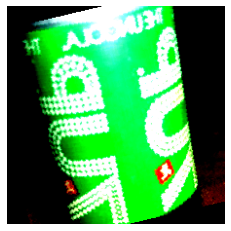

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  bottle
Prediction:  can


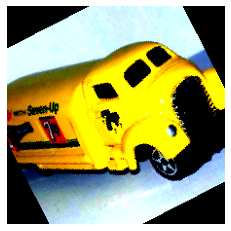

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  can
Prediction:  bottle


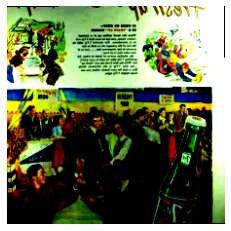

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  bottle
Prediction:  can


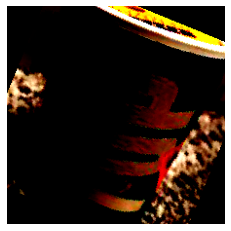

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  can
Prediction:  bottle


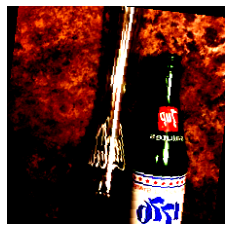

In [43]:
show_mistake(ensemble_vote, test_dataloader)